# Supermartingale Example

This notebook explains the concept of supermartingale certificates using the pendulum example. In this example, the system follows the following stochastic differential equation:

$$
\begin{align}
d \phi_t &= \Bigl(\frac{g}{l}\sin \theta_t + \frac{M u_t - b \phi_t}{ml^2}\Bigr)\,d t + \sigma\,d W_t\\
d \theta_t &= \phi_t\,d t
\end{align}
$$

where

- $\phi_t$ is the angular velocity of the pendulum,
- $\theta_t$ is the angle between the pendulum and the ordinate (i.e., vertical) axis,
- $u_t$ is the control signal (between -1 and 1) that applies extra torque to the pendulum,
- $M$ is the maximum torque (i.e., the scaling factor for the contol signal),
- $g$ is the gravitational constant,
- $l$ is the pendulum length,
- $m$ is the pendulum mass,
- $b$ is the friction coefficient,
- $\sigma$ is the random disturbance scale,
- $W_t$ is a Wiener (i.e., random Brownian) process that creates the disturbances.

The pendulum is controlled by a neural network and our goal is to certify that the resulting behavior adheres to a certain specification (defined later). This is done by producing a certificate, which is a function that satisfies certain properties. The existance of such a function is a proof that the system complies with the specification.

In this example, we use a pre-trained control policy and a cerfiticate. Both are given by neural networks.

## Loading the Neural Networks

We begin with defining two simple neural network architectures. The theoretical results require that the networks are twice continuously differentiable, so we use hyperbolic tangent activations. For the certificate, we also need non-negativity, so it has an extra softplus at the end for that.

In [1]:
import torch
from torch import nn

class TanhPolicy(nn.Sequential):
    """
    A policy with three layers and tanh activations between them.
    """

    def __init__(
        self,
        n_in: int = 2,
        n_out: int = 1,
        n_hidden: int = 64,
        device: torch.device | str = "cpu"
    ):
        super().__init__(
            nn.Linear(n_in, n_hidden, dtype=torch.float32, device=device),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, dtype=torch.float32, device=device),
            nn.Tanh(),
            nn.Linear(n_hidden, n_out, dtype=torch.float32, device=device),
        )


class CertificateModule(torch.nn.Sequential):
    """The RSA certificate"""

    def __init__(
        self,
        n_in: int = 2,
        n_out: int = 1,
        n_hidden: int = 32,
        device: torch.device | str = "cpu"
    ):
        super().__init__(
            nn.Linear(n_in, n_hidden, dtype=torch.float32, device=device),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, dtype=torch.float32, device=device),
            nn.Tanh(),
            nn.Linear(n_hidden, n_out, dtype=torch.float32, device=device),
            nn.Softplus()
        )

Next, we load a policy that we have pre-trained and saved to `pendulum_policy.pt`. Similarly, we load a pre-trained certificate from `pendulum_certificate.pt`.

In [2]:
rl_policy_net = TanhPolicy(2, 1, 64, device="cpu")
rl_policy_net.load_state_dict(torch.load(
    "pendulum_policy.pt",
    map_location="cpu",
    weights_only=True
))

certificate_net = CertificateModule(2, 1, 32, device="cpu")
certificate_net.load_state_dict(torch.load(
    "pendulum_certificate.pt",
    map_location="cpu",
    weights_only=True
))

<All keys matched successfully>

## Creating the Environment

Next, we need to plug the controller (policy network) into the environment. The environemnt is defined with the equations given above, see `controlled_sde` for the implementation details. The controlled SDE class is used in training (skipped here) but can also be used for sampling, which we do need for plotting.

In [3]:
import controlled_sde

sde = controlled_sde.InvertedPendulum(rl_policy_net)

## Creating the Specification

A reach-avoid-stay specification contains four sets and two constants:

- The domain set $\mathbb{X}$ to which the system is restricted.
- The initial set $\mathbb{X}_0$ where the system starts.
- The target set $\mathbb{X}_\star$ that the system needs to reach.
- The unsafe set $\mathbb{X}_\oslash$ that the system needs to avoid.
- The reach-avoid probability, that is, the probability to reach the target $\mathbb{X}_\star$ from the initial set $\mathbb{X}_\star$ while avoiding the unsafe states $\mathbb{X}_\oslash$.
- The stay probability of remaning in the target set $\mathbb{X}_\star$.

We use axis-aligned bounding boxes (AABBs) in this example. We define a class to describe a set given by a union of AABBs. The probabilities are needed for verification, but are not used in plotting (yet) so we don't actually need them for this example and they are included for completness.

Next, we create the boxes for the required sets. Each set is just a single AABB except for the unsafe set which is a union of two AABBs.

In [4]:
import numpy as np

# set the boundaries of the sets
global_bounds = np.array([[[-20.0, -2*np.pi], [20.0, 2*np.pi]]])
initial_bounds = np.array([[[-1.0, 3/4*np.pi], [1.0, 5/4*np.pi]]])
target_bounds = np.array([[[-4.0, -np.pi/2], [4.0, np.pi/2]]])
unsafe_bounds = np.array([
    [[-20.0, -2*np.pi], [-10.0, -3/2*np.pi]],
    [[10.0, 3/2*np.pi], [20.0, 2*np.pi]]
])

## Plotting

This is a visualization that we used in the paper.

We use simple colored boxes for the sets.

For the trajectories of the system (sample paths) we use white lines. These are not actually used in training, but are very useful for visualization properties. They are typically hard to obtain, but luckily there is a `torchsde` library that allows us to find sample paths by using numerical methods such as stochastic Runge-Kutta.

Finally, the certificate itself is visualized as a heatmap.

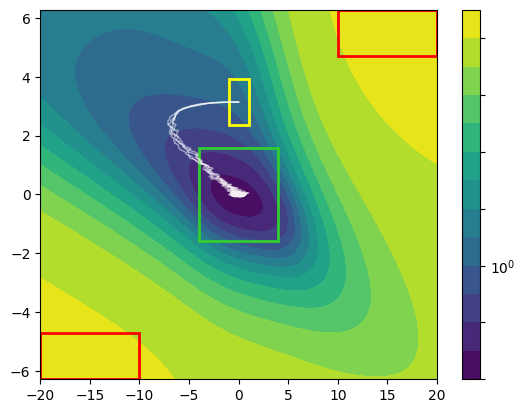

In [5]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle

STARTING_ANGLE = torch.pi    # starting angle for plotting sample paths
STARTING_SPEED = 0.0         # starting angular velocity
DURATION = 6                 # seconds
FPS = 200                    # frames per second
T_SIZE = DURATION * FPS + 1  # number of time steps for each sample path

# Initialize the batch of starting states all at the same point
x0 = torch.tile(torch.tensor([[STARTING_SPEED, STARTING_ANGLE]],
                             device="cpu"), dims=(4, 1))
# Initialize a time vector sampling at 200 Hz based on the FPS
ts = torch.linspace(0, DURATION, T_SIZE, device="cpu")

# Sample paths at times `ts` each starting at `x0` using
# stochastic Runge--Kutta method.
sample_paths = sde.sample(x0, ts, method="srk").squeeze()

# Plot
fig, ax1 = plt.subplots(1, 1)

with torch.no_grad():
    # create a grid of points to plot
    grid = torch.stack(
        torch.meshgrid(
            torch.linspace(global_bounds[0, 0, 0],
                           global_bounds[0, 1, 0], 101),
            torch.linspace(global_bounds[0, 0, 1],
                           global_bounds[0, 1, 1], 101),
            indexing='xy'
        )
    )
    grid = grid.reshape(2, -1).T

    # evaluate the certificate on the grid points and reshape the output
    out = certificate_net(grid).detach().numpy().reshape(101, 101)

    # set levels for contour plot based on the data range
    min_level = int(np.floor(np.log10(out.min()) * 5))
    max_level = int(np.ceil(np.log10(out.max()) * 5)) + 1

    # plot the certificate values as a contour plot
    c = ax1.contourf(
        np.linspace(global_bounds[0, 0, 0], global_bounds[0, 1, 0], 101),
        np.linspace(global_bounds[0, 0, 1], global_bounds[0, 1, 1], 101),
        out,
        norm=colors.LogNorm(),
        levels=[10 ** (n / 5) for n in range(min_level, max_level, 1)]
    )

# add colorbar to the plot
fig.colorbar(c, ax=ax1)

# plot the sets and sample paths
ax1.set_xlim(global_bounds[0, :, 0])
ax1.set_ylim(global_bounds[0, :, 1])

# plot the initial set
for i in range(initial_bounds.shape[0]):
    ax1.add_patch(Rectangle(initial_bounds[i, 0, :], *(initial_bounds[i, 1, :] - initial_bounds[i, 0, :]),
                            edgecolor='yellow',
                            facecolor='none',
                            lw=2))

# plot the target set
for i in range(target_bounds.shape[0]):
    ax1.add_patch(Rectangle(target_bounds[i, 0, :], *(target_bounds[i, 1, :] - target_bounds[i, 0, :]),
                            edgecolor='limegreen',
                            facecolor='none',
                            lw=2))

# plot the unsafe set
for i in range(unsafe_bounds.shape[0]):
    ax1.add_patch(Rectangle(unsafe_bounds[i, 0, :], *(unsafe_bounds[i, 1, :] - unsafe_bounds[i, 0, :]),
                            edgecolor='red',
                            facecolor='none',
                            lw=2))

# plot the sample paths
path_data = sample_paths.numpy()
ax1.plot(path_data[:, :, 0], path_data[:, :, 1],
         color="white", lw=1, alpha=0.5
         )

# finally, display the plot
plt.show()